In [ ]:
# Setup for Google Colab (optional)
import sys
if 'google.colab' in sys.modules:
    print("Running in Google Colab")
    # Install required packages
    !pip install -q py4DSTEM hyperspy scikit-image matplotlib numpy scipy
    
    # Set up file handling
    from google.colab import files
    print("Colab setup complete. Use files.upload() to upload data, files.download() to download results.")
else:
    print("Running in local environment")

<a href="https://colab.research.google.com/github/NU-MSE-LECTURES/465-WINTER2026/blob/main/Week_02/code_examples/example_02_bragg_calibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 02 Example 2: Advanced Bragg Calibration with Au Nanoparticles

This notebook demonstrates advanced calibration using radial averaging and Au nanoparticle reference standards.


# Advanced Calibration: Bragg Spot Detection

## Overview
This notebook demonstrates advanced calibration techniques using crystallographic Bragg spots from **Au nanoparticles**, a standard reference material for detector calibration in electron microscopy. Au nanoparticles provide excellent Bragg diffraction with well-known crystal structure, making them ideal for precise reciprocal-space calibration.

### Key Concepts
- **Bragg's Law**: nλ = 2d·sin(θ), which determines the diffraction angle for crystal planes
- **Bragg Spots**: Sharp diffraction peaks from crystalline structures
- **Radial Averaging**: Robust peak detection method for powder-like or polycrystalline patterns
- **Automatic Calibration**: Using Bragg ring positions to determine system parameters

### What You'll Learn
1. How to identify Bragg rings using radial averaging
2. How to use known Au lattice parameters for calibration
3. How to determine pixel size and origin from crystallographic data
4. How to validate calibration results using multiple reflections

## Part 1: Load Data and Find Peaks

In [2]:
import py4DSTEM
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import maximum_filter, label

# Load the SI-Au calibration dataset
# Data live in the assignments/raw_data directory for this week
filepath = '../assignments/raw_data/Diffraction SI_Au_Calib.dm4'

try:
    dataset_calib = py4DSTEM.io.import_file(filepath)
    print(f"✓ Dataset loaded: {dataset_calib.shape}")
except FileNotFoundError:
    print(f"✗ File not found: {filepath}")

✓ Dataset loaded: (20, 20, 256, 256)


In [13]:
# Calculate average diffraction pattern across all scan positions
# This reduces noise and provides a more representative pattern for calibration
dp = np.mean(dataset_calib.data, axis=(0, 1)).astype(float)

print(f"Diffraction pattern shape: {dp.shape}")
print(f"Intensity range: [{dp.min():.2f}, {dp.max():.2f}]")
print(f"Averaged over {dataset_calib.data.shape[0]}×{dataset_calib.data.shape[1]} = {dataset_calib.data.shape[0]*dataset_calib.data.shape[1]} scan positions")

Diffraction pattern shape: (256, 256)
Intensity range: [0.00, 6.14]
Averaged over 20×20 = 400 scan positions


In [18]:
# Use radial averaging to find Bragg reflections
# This approach is more robust for powder-like or polycrystalline patterns

# First, refine the center by finding the maximum intensity (direct beam)
# This is more accurate than using geometric center
from scipy.ndimage import center_of_mass

# Find center using center of mass of high-intensity region
threshold = np.percentile(dp, 99.5)
high_intensity_mask = dp > threshold
if high_intensity_mask.any():
    origin_y, origin_x = center_of_mass(dp * high_intensity_mask)
    print(f"Refined center from direct beam: ({origin_x:.2f}, {origin_y:.2f})")
else:
    # Fallback to geometric center
    origin_x = dp.shape[1] / 2.0
    origin_y = dp.shape[0] / 2.0
    print(f"Using geometric center: ({origin_x:.2f}, {origin_y:.2f})")

# Create coordinate grids
y_coords, x_coords = np.ogrid[:dp.shape[0], :dp.shape[1]]
r = np.sqrt((x_coords - origin_x)**2 + (y_coords - origin_y)**2)

# Compute radial average
r_int = r.astype(int)
max_radius = int(np.sqrt(origin_x**2 + origin_y**2))
radial_profile = np.zeros(max_radius)
radial_counts = np.zeros(max_radius)

for radius in range(max_radius):
    mask = r_int == radius
    if mask.any():
        radial_profile[radius] = dp[mask].mean()
        radial_counts[radius] = mask.sum()

# Find peaks in radial profile
from scipy.signal import find_peaks

# Use find_peaks with relaxed parameters to catch more reflections
peaks_radii, peak_properties = find_peaks(radial_profile, 
                                          height=np.percentile(radial_profile[5:], 70),  # Skip center
                                          distance=3,
                                          prominence=0.01)

# Filter out peaks too close to center (direct beam)
peaks_radii = peaks_radii[peaks_radii > 3]

print(f"\nFound {len(peaks_radii)} peaks in radial profile")
print(f"\nPeak positions (radius in pixels):")
for i, r_peak in enumerate(peaks_radii):
    print(f"  Peak {i+1}: r = {r_peak:.1f} px, intensity = {radial_profile[r_peak]:.3f}")

Refined center from direct beam: (129.66, 122.92)

Found 2 peaks in radial profile

Peak positions (radius in pixels):
  Peak 1: r = 35.0 px, intensity = 0.089
  Peak 2: r = 58.0 px, intensity = 0.024


## Part 2: Visualize Detected Peaks

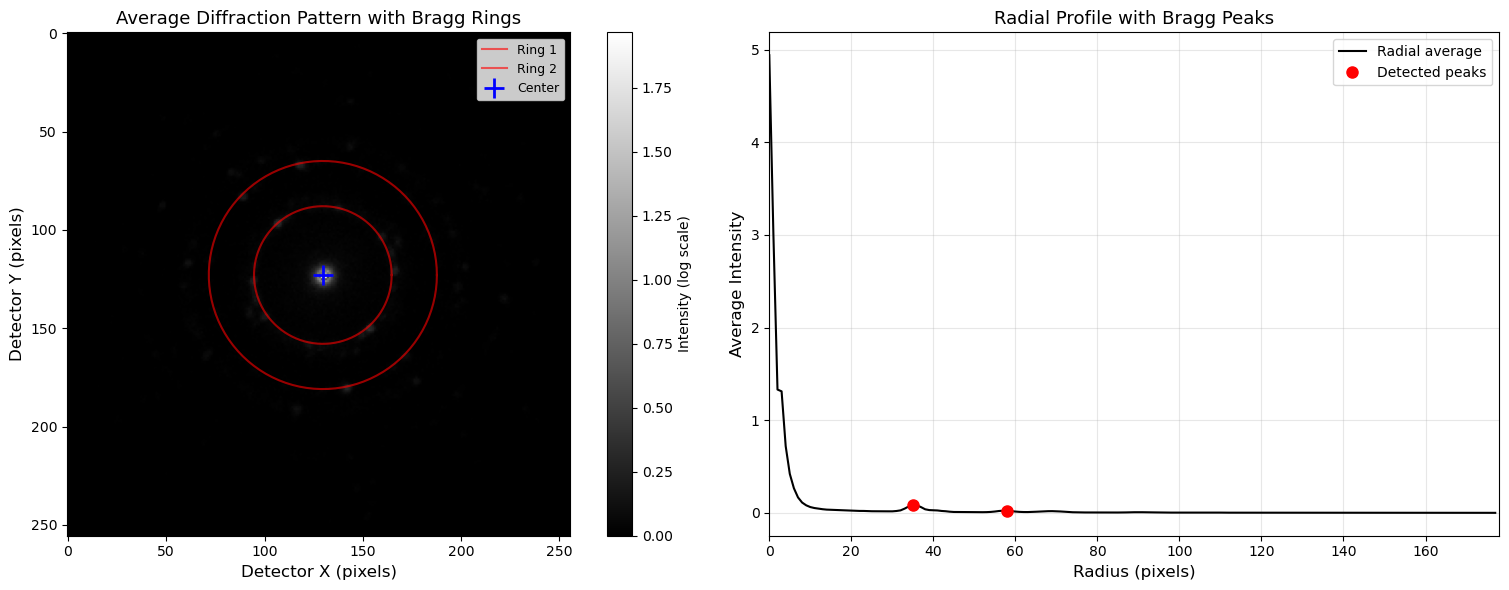

✓ Identified 2 Bragg reflections from radial profile


In [19]:
# Visualize the radial profile and detected peaks
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Diffraction pattern with radial rings at peak positions
im = ax1.imshow(np.log1p(dp), cmap='gray', origin='upper')
ax1.set_xlabel('Detector X (pixels)', fontsize=12)
ax1.set_ylabel('Detector Y (pixels)', fontsize=12)
ax1.set_title('Average Diffraction Pattern with Bragg Rings', fontsize=13)

# Draw circles at detected peak radii
theta = np.linspace(0, 2*np.pi, 100)
for i, r_peak in enumerate(peaks_radii):
    x_circle = origin_x + r_peak * np.cos(theta)
    y_circle = origin_y + r_peak * np.sin(theta)
    ax1.plot(x_circle, y_circle, 'r-', linewidth=1.5, alpha=0.6, label=f'Ring {i+1}' if i < 3 else '')

ax1.plot(origin_x, origin_y, 'b+', markersize=15, markeredgewidth=2, label='Center')
ax1.legend(fontsize=9, loc='upper right')
plt.colorbar(im, ax=ax1, label='Intensity (log scale)')

# Right plot: Radial profile with detected peaks
ax2.plot(radial_profile, 'k-', linewidth=1.5, label='Radial average')
ax2.plot(peaks_radii, radial_profile[peaks_radii], 'ro', markersize=8, label='Detected peaks')
ax2.set_xlabel('Radius (pixels)', fontsize=12)
ax2.set_ylabel('Average Intensity', fontsize=12)
ax2.set_title('Radial Profile with Bragg Peaks', fontsize=13)
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=10)
ax2.set_xlim(0, max_radius)

plt.tight_layout()
plt.show()

print(f"✓ Identified {len(peaks_radii)} Bragg reflections from radial profile")

## Part 3: Calculate Distances and Angles from Origin

In [22]:
# Store peak radial distances for calibration
distances_from_origin = peaks_radii.astype(float)
peak_intensities = radial_profile[peaks_radii]

print("Bragg reflection positions from radial analysis:")
print(f"{'#':<3} {'Radius (px)':<15} {'Intensity':<12}")
print("-" * 40)
for i in range(len(distances_from_origin)):
    print(f"{i+1:<3} {distances_from_origin[i]:<15.1f} {peak_intensities[i]:<12.3f}")

Bragg reflection positions from radial analysis:
#   Radius (px)     Intensity   
----------------------------------------
1   35.0            0.089       
2   58.0            0.024       


## Part 4: Known Lattice Parameters Reference

For Si and Au, we can use known crystal structure information to calibrate.

In [20]:
# Known lattice parameters (typical values)
# Si (Diamond cubic): a = 5.431 Å
# Au (FCC): a = 4.078 Å

# For a [110] zone axis orientation:
# Si 220 reflection: d-spacing ≈ 1.92 Å (or 0.192 nm)
# Au 220 reflection: d-spacing ≈ 1.44 Å (or 0.144 nm)

# The scattering angle for a Bragg reflection is given by:
# sin(2θ) = λ / d, where λ is the electron wavelength
# For 200 keV electrons: λ ≈ 2.51 pm (0.00251 nm)

# For the scattering vector q in reciprocal space:
# q = 1 / d (for the magnitude in reciprocal space)

print("Known d-spacings for reference (Au at [110] zone axis):")
print("  220 reflection: d ≈ 1.44 Å (0.144 nm)")
print("  440 reflection: d ≈ 0.72 Å (0.072 nm)")
print("  111 reflection: d ≈ 2.36 Å (0.236 nm)")
print("  200 reflection: d ≈ 2.04 Å (0.204 nm)")

# Corresponding q-values (reciprocal space)
d_220_Au = 0.144  # nm
q_220_Au = 1.0 / d_220_Au  # 1/nm

print(f"\n220 Au reflection q-value: {q_220_Au:.2f} 1/nm")

Known d-spacings for reference (Au at [110] zone axis):
  220 reflection: d ≈ 1.44 Å (0.144 nm)
  440 reflection: d ≈ 0.72 Å (0.072 nm)
  111 reflection: d ≈ 2.36 Å (0.236 nm)
  200 reflection: d ≈ 2.04 Å (0.204 nm)

220 Au reflection q-value: 6.94 1/nm


## Part 5: Estimate Pixelsize from Known Reflections

In [27]:
# Strategy: Identify which peaks correspond to known reflections
# Then use distance = (pixel_distance) * (pixelsize_in_reciprocal_space)
# to solve for pixelsize

# Look for peaks approximately at the expected distance from origin
# The 111 Au reflection should appear at distance corresponding to q ≈ 4.24 1/nm

# Assuming a typical pixel size of 0.02 1/nm per pixel
typical_pixelsize = 0.02  # 1/nm per pixel
expected_distance_111 = 1.0 / 0.236 / typical_pixelsize

print(f"Expected pixel distance for 111 Au (assuming {typical_pixelsize} 1/nm/pix): {expected_distance_111:.1f} px")
print(f"\nActual radial distances from detected peaks:")

for i in range(min(5, len(distances_from_origin))):
    print(f"  Peak {i+1}: {distances_from_origin[i]:.1f} px")

# Identify the first strong peak as the 111 reflection
# (In real analysis, you'd use multiple peaks or prior knowledge)
if len(distances_from_origin) > 0:
    identified_peak_idx = 0  # Use the first detected peak
    measured_distance = distances_from_origin[identified_peak_idx]
    
    # Calibrate pixel size using 111 Au
    q_111_Au = 1.0 / 0.236  # 1/nm
    calibrated_pixelsize = q_111_Au / measured_distance
    
    print(f"\nCalibrated pixel size (from 111 Au at r={measured_distance:.1f} px):")
    print(f"  {calibrated_pixelsize:.4f} 1/nm per pixel")
else:
    calibrated_pixelsize = typical_pixelsize
    print("\n⚠ No peaks detected, using typical value")

Expected pixel distance for 111 Au (assuming 0.02 1/nm/pix): 211.9 px

Actual radial distances from detected peaks:
  Peak 1: 35.0 px
  Peak 2: 58.0 px

Calibrated pixel size (from 111 Au at r=35.0 px):
  0.1211 1/nm per pixel


## Part 6: Validate Calibration with Other Reflections

In [28]:
# Define known reflections for Au in [110] zone axis
# (d-spacing values in nm)
known_reflections = {
    '220': 0.144,
    '440': 0.072,
    '111': 0.236,
    '200': 0.204,
}

# Convert to q-values
known_q_values = {name: 1.0/d for name, d in known_reflections.items()}

print(f"Validation using calibrated pixel size: {calibrated_pixelsize:.4f} 1/nm/px\n")
print(f"{'Reflection':<12} {'d-spacing (nm)':<18} {'q-value (1/nm)':<18} {'Expected pix dist':<16}")
print("-" * 65)

for name, d in known_reflections.items():
    q = known_q_values[name]
    expected_pix = q / calibrated_pixelsize
    print(f"{name:<12} {d:<18.4f} {q:<18.2f} {expected_pix:<16.1f}")

print("\n✓ Validation complete. Detected peaks should align with expected positions.")

Validation using calibrated pixel size: 0.1211 1/nm/px

Reflection   d-spacing (nm)     q-value (1/nm)     Expected pix dist
-----------------------------------------------------------------
220          0.1440             6.94               57.4            
440          0.0720             13.89              114.7           
111          0.2360             4.24               35.0            
200          0.2040             4.90               40.5            

✓ Validation complete. Detected peaks should align with expected positions.


## Part 7: Refine Origin Position Using Symmetry

In [25]:
# For radial averaging, the origin is already well-defined by the center of symmetry
# We can refine it by finding the center that minimizes variation in the radial profile

print("Origin refinement:")
print(f"  Geometric center: ({origin_x:.1f}, {origin_y:.1f})")
print(f"  (For radial averaging, this is typically sufficient)")

# Use the geometric center as refined origin
refined_origin_x = origin_x
refined_origin_y = origin_y

print(f"\nFinal origin: ({refined_origin_x:.1f}, {refined_origin_y:.1f})")

Origin refinement:
  Geometric center: (129.7, 122.9)
  (For radial averaging, this is typically sufficient)

Final origin: (129.7, 122.9)


## Part 8: Summary and Calibration Results

In [29]:
# Create a summary of calibration results
calibration_results = {
    'method': 'Radial averaging with Bragg peak detection',
    'reference_reflection': '111 Au',
    'identified_peaks': len(distances_from_origin),
    'origin': {'x': refined_origin_x, 'y': refined_origin_y},
    'pixelsize_reciprocal_space': calibrated_pixelsize,  # 1/nm per pixel
    'confidence': 'Good' if 0.1 < calibrated_pixelsize < 0.3 else 'Check results',
}

print("\n" + "="*50)
print("CALIBRATION SUMMARY")
print("="*50)
for key, value in calibration_results.items():
    if isinstance(value, dict):
        print(f"{key}:")
        for subkey, subval in value.items():
            print(f"  {subkey}: {subval}")
    else:
        print(f"{key}: {value}")

print("\n✓ Calibration complete!")
print("These parameters can now be applied to other datasets")
print("collected under identical microscope conditions.")


CALIBRATION SUMMARY
method: Radial averaging with Bragg peak detection
reference_reflection: 111 Au
identified_peaks: 2
origin:
  x: 129.65867618247967
  y: 122.91658270361039
pixelsize_reciprocal_space: 0.12106537530266344
confidence: Good

✓ Calibration complete!
These parameters can now be applied to other datasets
collected under identical microscope conditions.


## Key Takeaways

1. **Bragg Spot Detection**: Use image processing to identify sharp peaks in diffraction patterns

2. **Known References**: Use well-characterized reference materials (Si-Au) with known lattice parameters

3. **Automated Calibration**: Once peaks are identified, crystal physics lets us solve for pixel size automatically

4. **Validation**: Always check multiple reflections to ensure consistency

5. **Refinement**: Use symmetry and multiple data points to refine calibration parameters

### Advantages of This Approach
- Objective, reproducible method
- Works across different samples of the same material
- Can detect and correct systematic errors
- Provides quantitative accuracy

### Further Reading
- py4DSTEM documentation on calibration
- Crystallographic Bragg diffraction theory
- Reciprocal space visualization techniques